## This script follows up from (revised)torchvision_finetuning_instance_segmentation.ipynb, and attempts to perform pruning with Torch-Pruning (basic framework done) and OTOv2 (crashes the instance).

In [ ]:
!pip install torch==2.1.0 torchvision==0.16.0 torchaudio==2.1.0 --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118


In [ ]:
import subprocess
import os
if not os.path.exists('./PennFudanPed.zip'):
    # Use subprocess to run the wget command
    subprocess.run(['wget', 'https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip', '-O', './PennFudanPed.zip'])
else:
    print(f"The file PennFudanPed.zip already exists.")
if not os.path.exists('./PennFudanPed'):
    # Unzipping files
    !unzip PennFudanPed.zip
else:
    print(f"The file PennFudanPed.zip should already been unzipped.")

The file PennFudanPed.zip already exists.
The file PennFudanPed.zip should already been unzipped.


In [ ]:
import os
import torch

from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F


class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = read_image(img_path)
        mask = read_image(mask_path)
        # instances are encoded as different colors
        obj_ids = torch.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]
        num_objs = len(obj_ids)

        # split the color-encoded mask into a set
        # of binary masks
        masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)

        # get bounding box coordinates for each mask
        boxes = masks_to_boxes(masks)

        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)

        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Wrap sample and targets into torchvision tv_tensors:
        img = tv_tensors.Image(img)

        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img))
        target["masks"] = tv_tensors.Mask(masks)
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [ ]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# load a pre-trained model for classification and return
# only the features
backbone = torchvision.models.mobilenet_v2(weights="DEFAULT").features
# ``FasterRCNN`` needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
backbone.out_channels = 1280

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios
anchor_generator = AnchorGenerator(
    sizes=((32, 64, 128, 256, 512),),
    aspect_ratios=((0.5, 1.0, 2.0),)
)

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# ``OrderedDict[Tensor]``, and in ``featmap_names`` you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(
    featmap_names=['0'],
    output_size=7,
    sampling_ratio=2
)

# put the pieces together inside a Faster-RCNN model
model = FasterRCNN(
    backbone,
    num_classes=2,
    rpn_anchor_generator=anchor_generator,
    box_roi_pool=roi_pooler
)

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask,
        hidden_layer,
        num_classes
    )

    return model

In [ ]:
if not os.path.exists('./engine.py'):
  os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py")
  os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")
  os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py")
  os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py")
  os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")

# Since v0.15.0 torchvision provides `new Transforms API <https://pytorch.org/vision/stable/transforms.html>`_
# to easily write data augmentation pipelines for Object Detection and Segmentation tasks.
#
# Let’s write some helper functions for data augmentation /
# transformation:

from torchvision.transforms import v2 as T


def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)


# Testing ``forward()`` method (Optional)
# ---------------------------------------
#
# Before iterating over the dataset, it's good to see what the model
# expects during training and inference time on sample data.
import utils


model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    num_workers=4,
    collate_fn=utils.collate_fn
)

# For Training
images, targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images, targets)  # Returns losses and detections
print(output)

# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)  # Returns predictions
print(predictions[0])

{'loss_classifier': tensor(0.1759, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0443, grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0359, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0109, grad_fn=<DivBackward0>)}
{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([], grad_fn=<IndexBackward0>)}


In [ ]:
from engine import train_one_epoch, evaluate

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2
# use our dataset and defined transformations
dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('PennFudanPed', get_transform(train=False))

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    num_workers=2,
    collate_fn=utils.collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    num_workers=2,
    collate_fn=utils.collate_fn
)

# get the model using our helper function
model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

In [ ]:
# Load transfer learnt model
file_path = 'original_model.pth'
model = get_model_instance_segmentation(num_classes)
model.load_state_dict(torch.load(file_path))
model.to(device)

#Verifying outputs
evaluate(model, data_loader_test, device=device)
model.to('cuda')

creating index...
index created!
Test:  [ 0/50]  eta: 0:01:42  model_time: 1.8517 (1.8517)  evaluator_time: 0.0081 (0.0081)  time: 2.0413  data: 0.1799  max mem: 702
Test:  [49/50]  eta: 0:00:00  model_time: 0.0962 (0.1386)  evaluator_time: 0.0033 (0.0050)  time: 0.1139  data: 0.0042  max mem: 783
Test: Total time: 0:00:07 (0.1546 s / it)
Averaged stats: model_time: 0.0962 (0.1386)  evaluator_time: 0.0033 (0.0050)
Accumulating evaluation results...
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.875
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.997
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.973
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.732
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxD

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [ ]:
evaluate(model, data_loader_test, device=device)

creating index...
index created!
Test:  [ 0/50]  eta: 0:00:19  model_time: 0.1655 (0.1655)  evaluator_time: 0.0085 (0.0085)  time: 0.3893  data: 0.2137  max mem: 783
Test:  [49/50]  eta: 0:00:00  model_time: 0.0930 (0.1035)  evaluator_time: 0.0029 (0.0049)  time: 0.1078  data: 0.0035  max mem: 783
Test: Total time: 0:00:06 (0.1208 s / it)
Averaged stats: model_time: 0.0930 (0.1035)  evaluator_time: 0.0029 (0.0049)
Accumulating evaluation results...
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.875
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.997
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.973
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.732
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxD

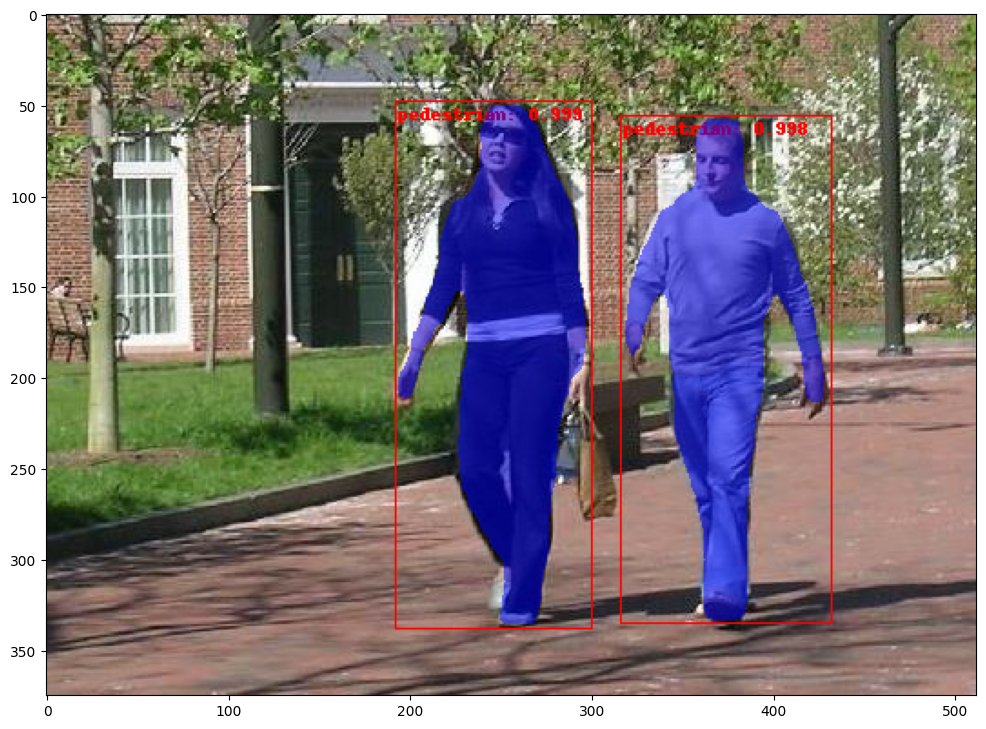

In [ ]:
import matplotlib.pyplot as plt

from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks

image = read_image("./PennFudanPed/PNGImages/PennPed00095.png")
eval_transform = get_transform(train=False)

model.eval()
with torch.no_grad():
    x = eval_transform(image)
    # convert RGBA -> RGB and move to device
    x = x[:3, ...].to(device)
    predictions = model([x, ])
    pred = predictions[0]


image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]
pred_labels = [f"pedestrian: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]
pred_boxes = pred["boxes"].long()
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")

masks = (pred["masks"] > 0.7).squeeze(1)
output_image = draw_segmentation_masks(output_image, masks, alpha=0.5, colors="blue")

plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))

In [ ]:
# Shift model back to CPU
model.to('cpu')

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

## Trying out pytorch-pruning

In [ ]:
!pip install --upgrade torch-pruning

In [ ]:
import torch_pruning as tp
from torch import nn
import copy
import gc
import time

In [ ]:
import sys
print(sys.setrecursionlimit(10000000))  # Set a higher limit
print(sys.getrecursionlimit())

None
10000000


In [ ]:
def replace_frozen_batch_norm(model):
    for name, module in reversed(model._modules.items()):
        if len(list(module.children())) > 0:
            model._modules[name] = replace_frozen_batch_norm(module)

        if isinstance(module, torchvision.ops.FrozenBatchNorm2d):
            # Replace with BatchNorm2d and initialize with FrozenBatchNorm2d statistics
            bn = nn.BatchNorm2d(module.weight.size(0), momentum=0.0, eps=module.eps, affine=True, track_running_stats=False)
            bn.running_mean = module.running_mean.clone()
            bn.running_var = module.running_var.clone()
            bn.weight.data = module.weight.clone()
            bn.bias.data = module.bias.clone()

            model._modules[name] = bn

    return model

def reverse_frozen_batch_norm(model):
    for name, module in reversed(model._modules.items()):
        if len(list(module.children())) > 0:
            model._modules[name] = reverse_frozen_batch_norm(module)

        if isinstance(module, torch.nn.BatchNorm2d):
            # Replace with FrozenBatchNorm2d and initialize with BatchNorm2d statistics
            fbn = torchvision.ops.FrozenBatchNorm2d(module.num_features)
            fbn.running_mean = module.running_mean.clone()
            fbn.running_var = module.running_var.clone()
            fbn.weight.data = module.weight.clone()
            fbn.bias.data = module.bias.clone()

            model._modules[name] = fbn

    return model

In [ ]:
!pip install wandb --upgrade

In [ ]:
import wandb

# key: 10db61a3ef94ff9f2335c6b442de16fe0abdf39f
wandb.login()

sweep_config = {
    'method': 'grid'
}

# Setting parameter sweep
parameters_dict = {
    'importance': {
        'values': [1, 2, 3]
    },
    'iterative_steps':{
        'values': [1, 10]
    },
    'pruning_ratio':{
        'values': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    }
}

sweep_config['parameters'] = parameters_dict

# View the dictionary
import pprint

pprint.pprint(sweep_config)


wandb: Currently logged in as: jf3482 (hpml-f23-proj). Use `wandb login --relogin` to force relogin


{'method': 'grid',
 'parameters': {'importance': {'values': [1, 2, 3]},
                'iterative_steps': {'values': [1, 10]},
                'pruning_ratio': {'values': [0.1,
                                             0.2,
                                             0.3,
                                             0.4,
                                             0.5,
                                             0.6,
                                             0.7,
                                             0.8,
                                             0.9]}}}


In [ ]:
# Step 2: Setting up the sweep controller
sweep_id = wandb.sweep(sweep_config, project = 'hpml-project-torchpruning_retrain')

Create sweep with ID: w6o8eord
Sweep URL: https://wandb.ai/hpml-f23-proj/hpml-project-torchpruning_retrain/sweeps/w6o8eord


In [ ]:
def prune(config=None):
  with wandb.init(config=config, resume=True):
    print_every = 1

    #Empty cache with each run
    torch.cuda.empty_cache()
    gc.collect()

    #Update config
    config = wandb.config
    importance = config.importance
    iterative_steps = config.iterative_steps
    pruning_ratio = config.pruning_ratio

    #Copy model
    test_model = copy.deepcopy(model)

    #Replace frozen batch norm (if this is not done, the pruner will not prune the batchnorm layers to be consistent with the other layers)
    test_model = replace_frozen_batch_norm(test_model)
    test_model.to(device)

    #Run the model
    test_model.eval()

    for p in test_model.parameters():
        p.requires_grad_(True)

    example_inputs = torch.randn(1, 3, 400, 400).to(device)

    base_macs, base_nparams = tp.utils.count_ops_and_params(test_model, example_inputs)
    print("Before Pruning: MACs=%f, #Params=%f"%(base_macs, base_nparams))

    if importance == 1:
      imp = tp.importance.MagnitudeImportance(p=2) # L2 norm pruning
    elif importance == 2:
      imp = tp.importance.RandomImportance() # Random importance
    elif importance == 3:
      imp = tp.importance.BNScaleImportance() # BN scale importance

    for i in range(iterative_steps):
        step = i
        print(i)

        #Set ignored layers
        ignored_layers = []
        for n, m in test_model.named_modules():
            if (isinstance(m, nn.Conv2d) and (m.out_channels == 2 or m.out_channels == 3 or m.out_channels == 12)) \
                or isinstance(m, nn.Linear)\
                or (n[:12]== 'backbone.fpn'):
                ignored_layers.append(m)

        print('Pruning')
        pruner = tp.pruner.MagnitudePruner(
            test_model,
            example_inputs,
            global_pruning = False,
            importance=imp,
            iterative_steps=iterative_steps,
            pruning_ratio=pruning_ratio,
            ignored_layers=ignored_layers,
        )

        pruner.step()

        # Retraining (5 epochs)
        print('Retraining')

        # construct an optimizer
        params = [p for p in test_model.parameters() if p.requires_grad]
        optimizer = torch.optim.SGD(
            params,
            lr=0.005,
            momentum=0.9,
            weight_decay=0.0005
        )

        # and a learning rate scheduler
        lr_scheduler = torch.optim.lr_scheduler.StepLR(
            optimizer,
            step_size=3,
            gamma=0.1
        )

        test_model = reverse_frozen_batch_norm(test_model)
        num_epochs = 5
        for epoch in range(num_epochs):
            test_model.train()
            # train for one epoch, printing every 10 iterations
            train_one_epoch(test_model, optimizer, data_loader, device, epoch, print_freq=10)
            # update the learning rate
            lr_scheduler.step()
            # evaluate on the test dataset
            test_model.eval()
            evaluate(test_model, data_loader_test, device=device)

        test_model = replace_frozen_batch_norm(test_model)

    pruned_macs, pruned_nparams = tp.utils.count_ops_and_params(test_model, example_inputs)
    print("After Pruning: MACs=%f, #Params=%f"%(pruned_macs, pruned_nparams))

    ## Verifying outputs
    #Timed
    start = time.monotonic()
    results = evaluate(test_model, data_loader_test, device=device)
    end = time.monotonic()
    elapsed_time = end - start

    # Logging loss into wandb
    wandb.log({"base_macs": base_macs})
    wandb.log({"base_nparams": base_nparams})
    wandb.log({"pruned_macs": pruned_macs})
    wandb.log({"pruned_nparams": pruned_nparams})
    wandb.log({"results_bbox": results.coco_eval['bbox'].stats[0]})
    wandb.log({"results_segm": results.coco_eval['segm'].stats[0]})
    wandb.log({"elapsed_time": elapsed_time})

    # Clearing memory for next iteration
    del test_model


In [ ]:
# Step 3: Running the sweep agent
wandb.agent(sweep_id, prune)

Output hidden; open in https://colab.research.google.com to view.